# Predicting Best Ball Playoff Teams with the Best Ball Value Curve and a Stacked XGBoost Model

### Participant: Philippe Tousignant
https://www.linkedin.com/in/ptousignant/   
https://medium.com/@philippetousignant   
https://github.com/philtousi    
https://twitter.com/phtousi   

## Main contributions

- The Best Ball Value Curve, a negative exponential curve explaining the relationship the between overall pick number and the pick points.
- A Stacked XGBoost Model predicting playoff teams with 97% ROC-AUC score and 95% accuracy.
- An analysis of the most predictive features of the model, and how it can assess individual roster.

## Utilities

In [1]:
########################################################
# Need to restart kernel after installing the packages #
########################################################

# Ideally on python 3.10.10

%pip install fuzzywuzzy==0.18.0
%pip install matplotlib==3.7.1
%pip install mlxtend==0.22.0
%pip install nfl_data_py==0.3.0
%pip install numpy==1.23.5
%pip install pandas==1.5.3
%pip install scikit_learn==1.2.2
%pip install scipy==1.10.1
%pip install shap==0.41.0
%pip install xgboost==1.7.4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from  itertools import product
from fuzzywuzzy import fuzz

from nfl_data_py import import_seasonal_data, import_rosters

from xgboost import XGBClassifier
from shap import TreeExplainer
from shap.plots import waterfall, beeswarm
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(transform_output='pandas')

from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/underdog/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

This section begins with downloading all regular season data for the 2021 and 2022 seasons, followed by the presentation of the Best Ball Value Curve. Lastly, the dataset is enriched with several variables from the nflpy library.

In [3]:
data = pd.DataFrame()
p_data = pd.DataFrame()

# 2022 regular season data
path = "../data/2022/regular_season/fast/"
for r, d, f in os.walk(path):
    for file in f:
        if 'csv' in file:
            df = pd.read_csv(os.path.join(r, file))
            data = pd.concat([data,df])
            data['year'] = 2022

path = "../data/2022/regular_season/mixed/"
for r, d, f in os.walk(path):
    for file in f:
        if 'csv' in file:
            df = pd.read_csv(os.path.join(r, file))
            data = pd.concat([data,df])
            data['year'] = 2022

# 2021 regular season data        
path = "../data/2021/regular_season/"
for r, d, f in os.walk(path):
    for file in f:
        if 'csv' in file:
            df = pd.read_csv(os.path.join(r, file))
            p_data = pd.concat([p_data,df])
            p_data['year'] = 2021

# Merge 2021 and 2022 data
data = pd.concat([data,p_data])
data = data.reset_index(drop=True)
data.head()

draft_id                  draft_time  clock  \
0  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
1  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
2  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
3  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
4  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   

                         draft_entry_id                   tournament_entry_id  \
0  99c03ad3-1162-4c21-8e59-1511393f1548  33e319d9-ac81-48d8-89b8-e66b7dcab3d6   
1  5486f630-4676-48d6-9343-2b760484ece6  5042797a-c80e-4cf6-b84b-34f98fa3224d   
2  6305bc02-4e38-4a4d-ae45-4a7496c33226  75d7adc6-2795-4fb3-b9db-2fa4a2e896a1   
3  99c03ad3-1162-4c21-8e59-1511393f1548  33e319d9-ac81-48d8-89b8-e66b7dcab3d6   
4  9471a977-fdc2-47a1-bf8c-9ead0d9f8d8e  62948f4c-ac38-4d06-b35a-ba88e4ecd346   

        tournament_round_draft_entry_id  tournament_round_number  \
0  8e53cbab-197f-4728-abbd-a52db326643c                        1   
1  62cae918-a2b6-4ded-9996-37c1f6fc7681                        1   
2  1b70668e-4783-4869-be3f-8d918a89a4a3                        1   
3  8e53cbab-197f-4728-abbd-a52db326643c                        1   
4  6b217ff8-0b10-4e55-a495-466d53c398bc                        1   

     player_name position_name  bye_week  projection_adp  pick_order  \
0   Hayden Hurst            TE        10          177.15           2   
1   Kirk Cousins            QB         7          116.96           3   
2  Austin Ekeler            RB         8            6.20           5   
3    Davis Mills            QB         6          203.75           2   
4  Davante Adams            WR         6           10.82          11   

   overall_pick_number  team_pick_number  pick_points  roster_points  \
0                  170                15        60.30        1424.96   
1                  118                10       161.20        1412.96   
2                    5                 1       237.00        1242.60   
3                  194                17        34.58        1424.96   
4                   11                 1       236.90        1413.98   

   playoff_team  year  
0             0  2022  
1             0  2022  
2             0  2022  
3             0  2022  
4             0  2022

In [4]:
# Negative exponential function
def neg_exp(x, a, k, b):
    return a * np.exp(-k*x) + b

In [5]:
# Function to remove outliers
def is_outlier(s, threshold=3):
    lower_limit = s.mean() - (s.std() * threshold)
    upper_limit = s.mean() + (s.std() * threshold)
    return ~s.between(lower_limit, upper_limit)

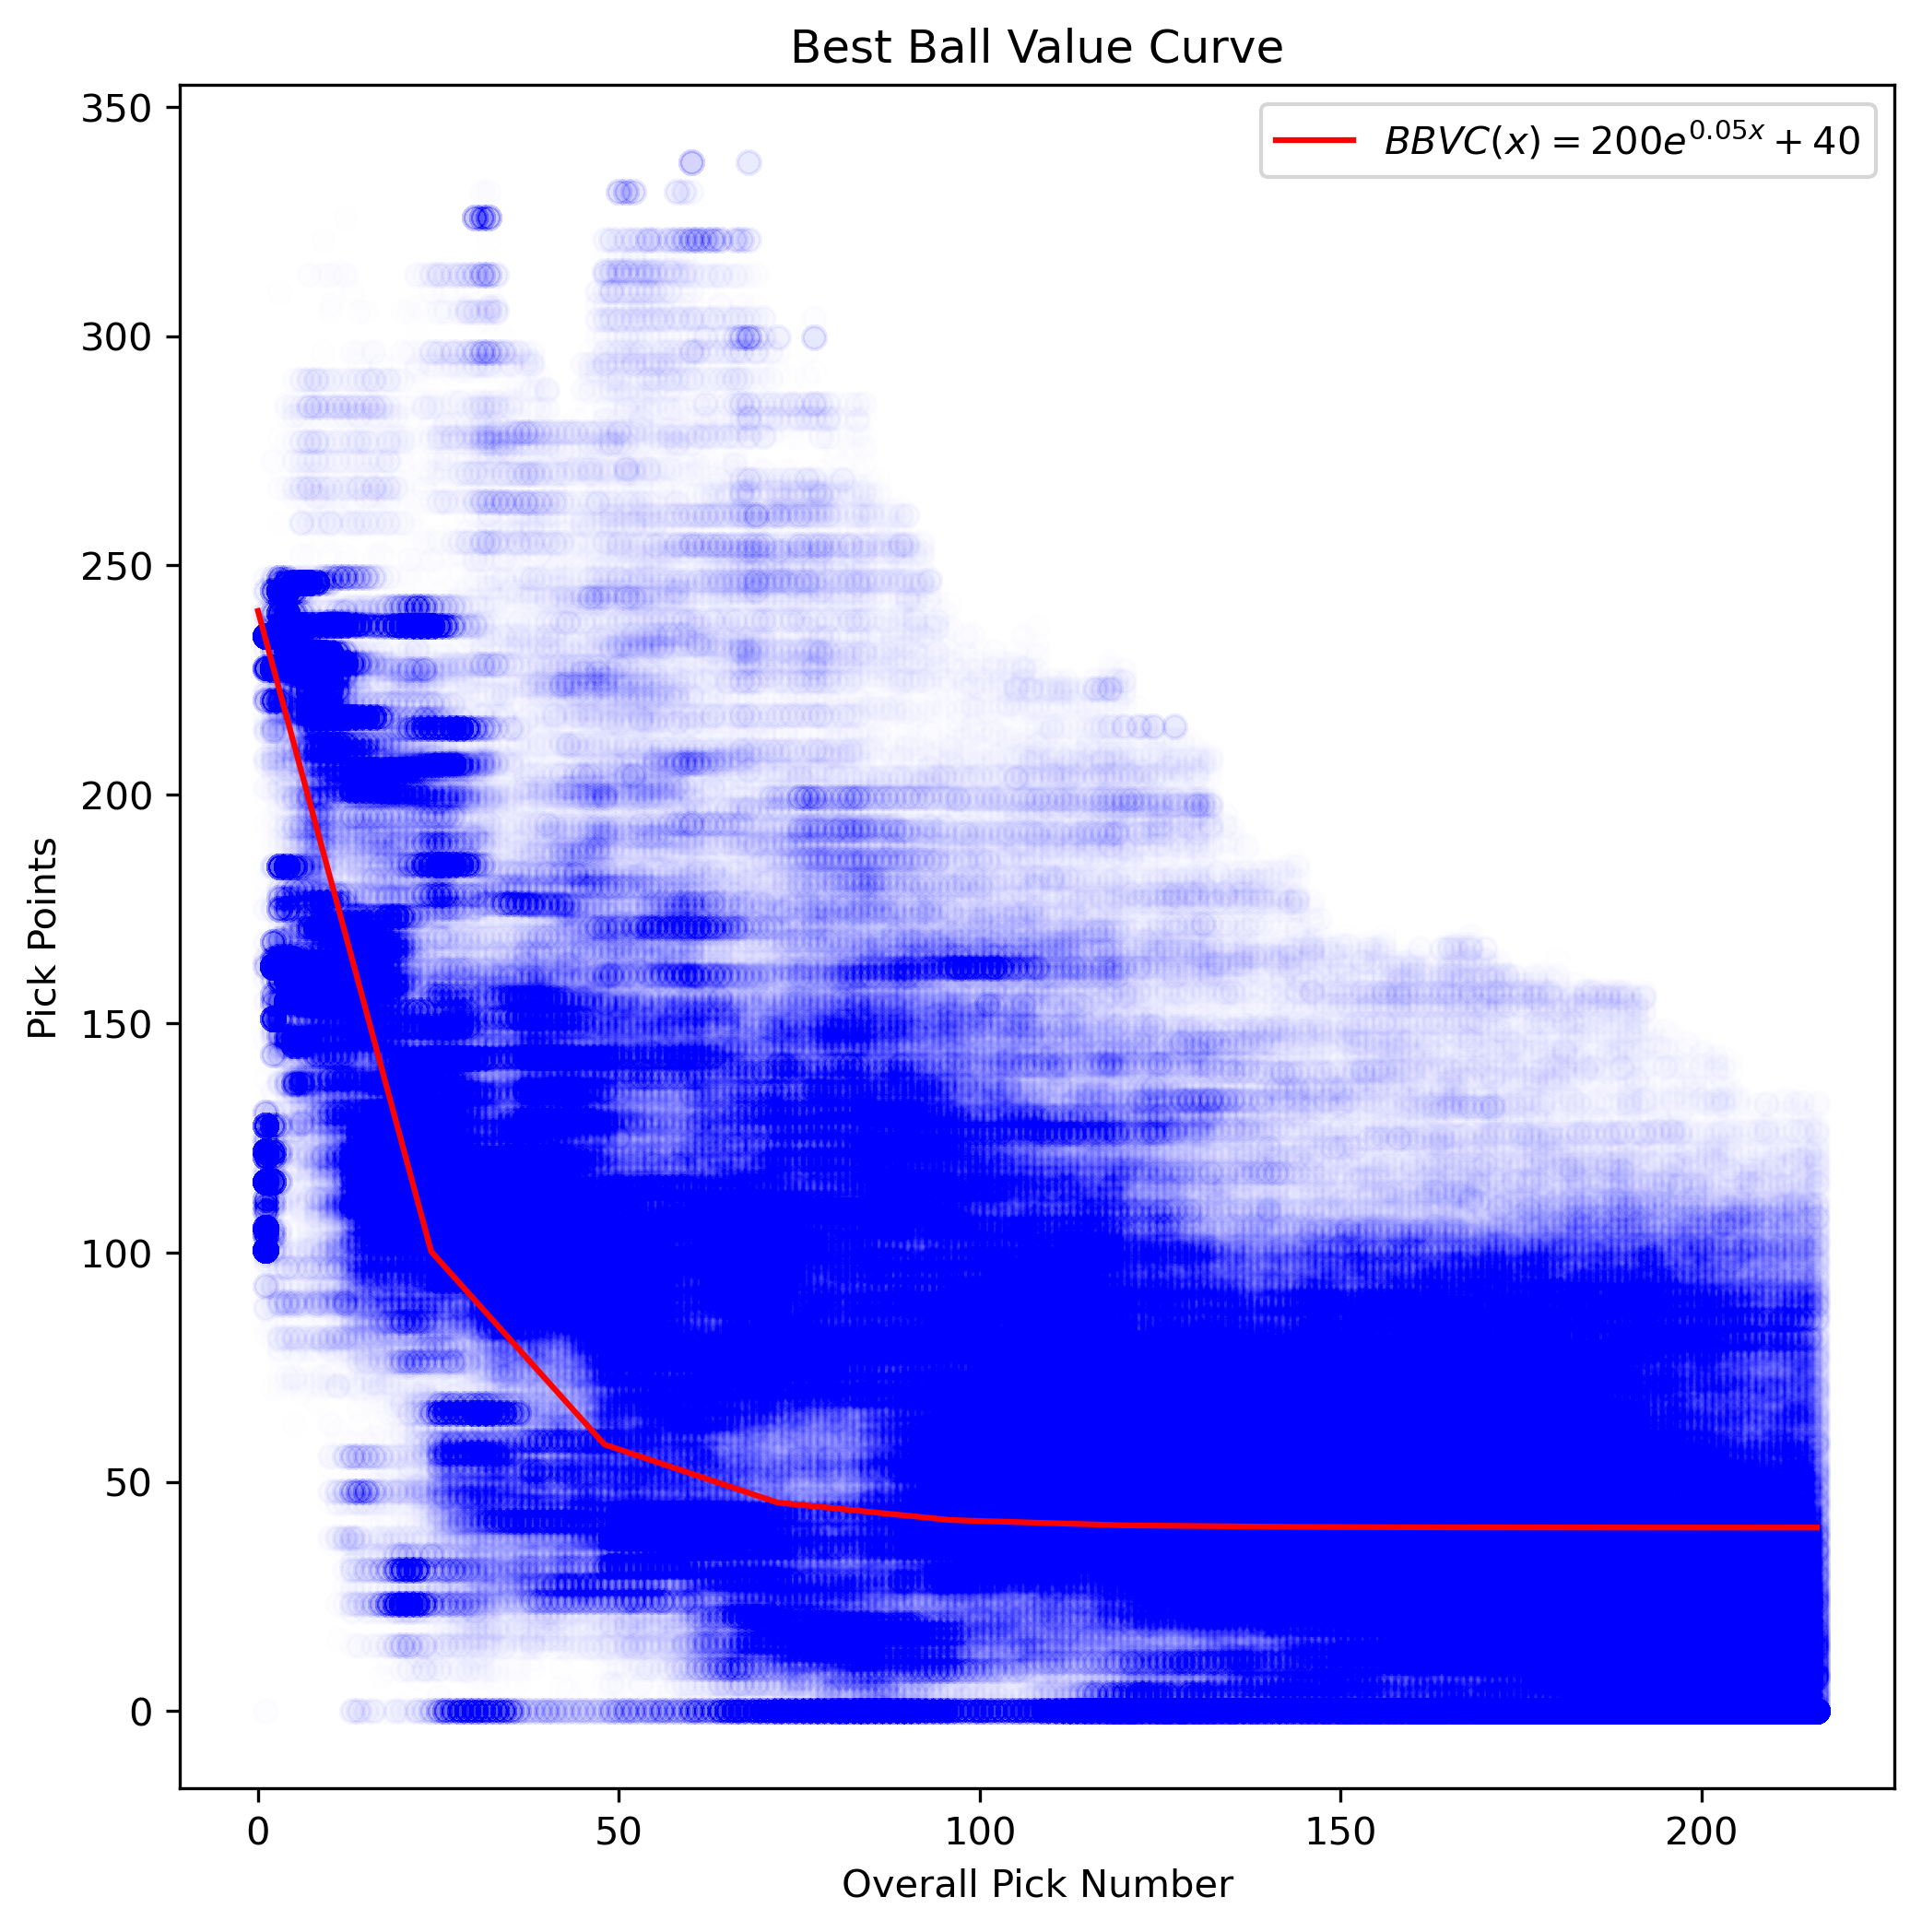

In [6]:
# BBVC parameters
a = 200
k = 0.05
b = 40

# Remove outliers, only for plotting purposes
filter = data.groupby('overall_pick_number')['pick_points'].apply(is_outlier)
f_data = data.loc[~filter].sample(frac=0.05)

# Utils to plot the BBVC
y = f_data['pick_points']
X = f_data['overall_pick_number']
x2 = np.linspace(0, 216, 10)
y2 = neg_exp(x2, a, k, b)

# Plot the best ball value curve
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X, y, 'bo',alpha=0.002)
ax.plot(x2, y2, color='r', label='$BBVC(x) = %.0f e^{%.2f x} %+.0f$' % (a,k,b))
ax.legend(loc='best')
plt.xlabel("Overall Pick Number")
plt.ylabel("Pick Points")
plt.title('Best Ball Value Curve')
plt.show()

The BBVC, when applied to the overall pick number, represents the expected points generated by each overall draft slots. This can also be interpreted as the draft capital (DC). When the same curve is applied to the ADP, it can be interpreted as the effective expected value generated by a pick or effective draft capital (DC_e). Both of these curve will be used later on to create powerful features. I also added some bias to the curve to make it steeper because it was more predictive. 

In [7]:
stats = import_seasonal_data([2020,2021]) # import players stats from 2020 and 2021, essentially lagged stats
stats['season'] = stats['season'] +1 # for easier merged between player data and lagged player stats
player_data = import_rosters([2021,2022]) # import player data from 2021 and 2022

nflpy = pd.merge(stats, player_data, how='inner', on=['season','player_id'],suffixes = (None, '_y'))

# Data transformation for future feature engeering
nflpy['name'] = nflpy['football_name'] + ' ' + nflpy['last_name']
nflpy['bmi'] = nflpy['weight'] / (nflpy['height'] * nflpy['height'])
nflpy['age'] = nflpy['season'] - pd.to_datetime(nflpy['birth_date']).dt.year
nflpy['draft_number_adj'] = nflpy['draft_number'].apply(neg_exp, args=(a, k, b))
nflpy['fantasy_points_per_game'] = (nflpy['fantasy_points_ppr'] - nflpy['receptions']*0.5) / nflpy['games']
nflpy['completions_per_game'] = nflpy['completions'] / nflpy['games']
nflpy['attempts_per_game'] = nflpy['attempts'] / nflpy['games']
nflpy['passing_yards_per_game'] = nflpy['passing_yards'] / nflpy['games']
nflpy['passing_tds_per_game'] = nflpy['passing_tds'] / nflpy['games']
nflpy['interceptions_per_game'] = nflpy['interceptions'] / nflpy['games']
nflpy['passing_air_yards_per_game'] = nflpy['passing_air_yards'] / nflpy['games']
nflpy['passing_yards_after_catch_per_game'] = nflpy['passing_yards_after_catch'] / nflpy['games']
nflpy['rushing_attempts_per_game'] = nflpy['attempts'] / nflpy['games']
nflpy['rushing_yards_per_game'] = nflpy['rushing_yards'] / nflpy['games']
nflpy['rushing_tds_per_game'] = nflpy['rushing_tds'] / nflpy['games']
nflpy['receptions_per_game'] = nflpy['receptions'] / nflpy['games']
nflpy['targets_per_game'] = nflpy['targets'] / nflpy['games']
nflpy['receiving_yards_per_game'] = nflpy['receiving_yards'] / nflpy['games']
nflpy['receiving_tds_per_game'] = nflpy['receiving_tds'] / nflpy['games']
nflpy['receiving_air_yards_per_game'] = nflpy['receiving_air_yards'] / nflpy['games']
nflpy['receiving_yards_after_catch_per_game'] = nflpy['receiving_yards_after_catch'] / nflpy['games']

# All columns required from nflpy and nflpy transformations
nflpy = nflpy[['name','season','team','age','bmi','draft_number','draft_number_adj','fantasy_points_per_game','fantasy_points_ppr','games',
               'receptions','targets','passing_tds','interceptions','passing_epa','receiving_epa','carries','rushing_epa','rushing_tds','receiving_tds','target_share',
               'passing_yards','passing_air_yards','passing_yards_after_catch','rushing_yards','receiving_yards','receiving_air_yards','receiving_yards_after_catch',
               'air_yards_share','attempts', 'completions','pacr','dakota','sack_fumbles','rushing_fumbles','receiving_fumbles','racr','wopr_x','yac_sh','ry_sh','rtd_sh',
               'rfd_sh','dom','w8dom','yptmpa','ppr_sh',
               'completions_per_game','attempts_per_game','passing_yards_per_game','passing_tds_per_game','interceptions_per_game','passing_air_yards_per_game','passing_yards_after_catch_per_game',
               'rushing_attempts_per_game','rushing_yards_per_game','rushing_tds_per_game',
               'receptions_per_game','targets_per_game','receiving_yards_per_game','receiving_tds_per_game','receiving_air_yards_per_game','receiving_yards_after_catch_per_game',]]
nflpy = nflpy.query('fantasy_points_ppr > 0')
nflpy.head()

name  season team   age       bmi  draft_number  \
0           Tom Brady    2021   TB  44.0  0.038954         199.0   
1           Tom Brady    2022   TB  45.0  0.038954         199.0   
2          Drew Brees    2021   NO   NaN       NaN          32.0   
3            Andy Lee    2021  ARI  39.0  0.034716         188.0   
5  Ben Roethlisberger    2021  PIT  39.0  0.040479          11.0   

   draft_number_adj  fantasy_points_per_game  fantasy_points_ppr  games  ...  \
0         40.009546                21.120000              337.92     16  ...   
1         40.009546                22.043529              374.74     17  ...   
2         80.379304                17.456667              209.48     12  ...   
3         40.016545                 1.040000                1.04      1  ...   
5        155.389962                17.814667              267.22     15  ...   

   passing_yards_after_catch_per_game  rushing_attempts_per_game  \
0                          113.125000                  38.125000   
1                          149.058824                  42.294118   
2                          123.166667                  32.500000   
3                           12.000000                   1.000000   
5                          130.200000                  40.533333   

   rushing_yards_per_game  rushing_tds_per_game  receptions_per_game  \
0                0.375000              0.187500                  0.0   
1                4.764706              0.117647                  0.0   
2               -0.166667              0.166667                  0.0   
3                0.000000              0.000000                  0.0   
5                0.733333              0.000000                  0.0   

   targets_per_game  receiving_yards_per_game  receiving_tds_per_game  \
0               0.0                       0.0                     0.0   
1               0.0                       0.0                     0.0   
2               0.0                       0.0                     0.0   
3               0.0                       0.0                     0.0   
5               0.0                       0.0                     0.0   

   receiving_air_yards_per_game  receiving_yards_after_catch_per_game  
0                           0.0                                   0.0  
1                           0.0                                   0.0  
2                           0.0                                   0.0  
3                           0.0                                   0.0  
5                           0.0                                   0.0  

[5 rows x 62 columns]

In [8]:
# Create fuzzy matches to merge best ball data and nflpy data
N = 50
names = {tup: fuzz.ratio(*tup) for tup in 
           product(data['player_name'].unique().tolist(), nflpy['name'].unique().tolist())}

s1 = pd.Series(names)
s1 = s1[s1 > N]
s1 = s1[s1.groupby(level=0).idxmax()]

# Merge best ball data and nflpy data after fuzzy matching
nflpy['name'] = nflpy['name'].map(s1).fillna(nflpy['name'])
data = pd.merge(data, nflpy, left_on = ['player_name', 'year'],right_on=['name','season'], how = 'left')

## Feature engineering

This is the crucial stage where I create over 300 roster-based customized features that span across various areas. The first set of features are generated from the best ball data itself and encompass aspects like position allocation, bye weeks, and the BBVC applied to the overall pick number (DC) and the ADP (DC_e). The second set of features are generated from nflpy and comprise general information about players such as age and the BMI. Additionally, they include several features relating to a player's previous year's performance. It is noteworthy that the final features are never specific to any particular player; instead, they either represent aggregate or positional statistics for the roster. Below, I have renamed all the features to simplify understanding.

In [9]:
data['DC'] = data['overall_pick_number'].apply(neg_exp, args=(a, k, b)) # Apply BBVC to overall pick number
data['DC_e'] = data['projection_adp'].apply(neg_exp, args=(a, k, b)) # Apply BBVC to the projection adp 
data['missing'] = data['bmi'].isna().astype(int) # Create missing flag for players that have no nflpy data the previous year (rookies, injured, etc.)
data.head()

draft_id                  draft_time  clock  \
0  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
1  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
2  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
3  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   
4  bed5abf0-9f8a-4ee5-bcc2-b86c4735afc5  2022-08-15 06:04:54.011858     30   

                         draft_entry_id                   tournament_entry_id  \
0  99c03ad3-1162-4c21-8e59-1511393f1548  33e319d9-ac81-48d8-89b8-e66b7dcab3d6   
1  5486f630-4676-48d6-9343-2b760484ece6  5042797a-c80e-4cf6-b84b-34f98fa3224d   
2  6305bc02-4e38-4a4d-ae45-4a7496c33226  75d7adc6-2795-4fb3-b9db-2fa4a2e896a1   
3  99c03ad3-1162-4c21-8e59-1511393f1548  33e319d9-ac81-48d8-89b8-e66b7dcab3d6   
4  9471a977-fdc2-47a1-bf8c-9ead0d9f8d8e  62948f4c-ac38-4d06-b35a-ba88e4ecd346   

        tournament_round_draft_entry_id  tournament_round_number  \
0  8e53cbab-197f-4728-abbd-a52db326643c                        1   
1  62cae918-a2b6-4ded-9996-37c1f6fc7681                        1   
2  1b70668e-4783-4869-be3f-8d918a89a4a3                        1   
3  8e53cbab-197f-4728-abbd-a52db326643c                        1   
4  6b217ff8-0b10-4e55-a495-466d53c398bc                        1   

     player_name position_name  bye_week  ...  rushing_tds_per_game  \
0   Hayden Hurst            TE        10  ...                0.0000   
1   Kirk Cousins            QB         7  ...                0.0625   
2  Austin Ekeler            RB         8  ...                0.7500   
3    Davis Mills            QB         6  ...                0.0000   
4  Davante Adams            WR         6  ...                0.0000   

   receptions_per_game  targets_per_game  receiving_yards_per_game  \
0             2.166667          2.583333                 18.416667   
1             0.000000          0.000000                  0.000000   
2             4.375000          5.875000                 40.437500   
3             0.000000          0.000000                  0.000000   
4             7.687500         10.562500                 97.062500   

   receiving_tds_per_game  receiving_air_yards_per_game  \
0                  0.2500                     17.083333   
1                  0.0000                      0.000000   
2                  0.5000                     10.687500   
3                  0.0000                      0.000000   
4                  0.6875                    100.125000   

   receiving_yards_after_catch_per_game          DC        DC_e  missing  
0                              7.416667   40.040694   40.028462        0  
1                              0.000000   40.547889   40.577133        0  
2                             39.187500  195.760157  186.689391        0  
3                              0.000000   40.012257   40.007528        0  
4                             38.312500  155.389962  156.433159        0  

[5 rows x 83 columns]

In [10]:
# All the features
trans = [
data.groupby('tournament_entry_id')['playoff_team'].first(), # Target
data.groupby('tournament_entry_id')['draft_id'].first(), # Groups

# Best Ball data features
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC'].sum()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['player_name'].count()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC'].sum()/data.groupby(['tournament_entry_id','position_name'])['player_name'].count()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC_e'].sum()/data.groupby(['tournament_entry_id','position_name'])['player_name'].count()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby('tournament_entry_id')['DC'].sum()),
pd.DataFrame(data.groupby('tournament_entry_id')['DC_e'].sum()),
pd.DataFrame(data.groupby('tournament_entry_id')['DC_e'].sum()/data.groupby('tournament_entry_id')['DC'].sum()),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC_e'].sum()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC_e'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['DC'].sum()/data.groupby(['tournament_entry_id','position_name'])['DC_e'].sum()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['bye_week'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
data.groupby('tournament_entry_id')['pick_order'].first(),
data.groupby('tournament_entry_id')['bye_week'].std(),

# NFLPY Features
data.groupby('tournament_entry_id')['missing'].mean(),
data.groupby('tournament_entry_id')['missing'].std(),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['missing'].sum()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['missing'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
data.groupby('tournament_entry_id')['team'].apply('count'),

data.groupby('tournament_entry_id')['age'].mean(),
data.groupby('tournament_entry_id')['bmi'].mean(),
data.groupby('tournament_entry_id')['draft_number'].mean(),
data.groupby('tournament_entry_id')['draft_number_adj'].mean(),
data.groupby('tournament_entry_id')['fantasy_points_per_game'].mean(),
data.groupby('tournament_entry_id')['games'].mean(),
data.groupby('tournament_entry_id')['ppr_sh'].mean(),
data.groupby('tournament_entry_id')['age'].std(),
data.groupby('tournament_entry_id')['bmi'].std(),
data.groupby('tournament_entry_id')['draft_number'].std(),
data.groupby('tournament_entry_id')['draft_number_adj'].std(),
data.groupby('tournament_entry_id')['fantasy_points_per_game'].std(),
data.groupby('tournament_entry_id')['games'].std(),
data.groupby('tournament_entry_id')['ppr_sh'].std(),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['age'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['bmi'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['draft_number'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['draft_number_adj'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['fantasy_points_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['games'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['ppr_sh'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['age'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['bmi'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['draft_number'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['draft_number_adj'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['fantasy_points_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['games'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['ppr_sh'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),

pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['attempts'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['attempts'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['completions'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['completions'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_air_yards'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_air_yards'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards_after_catch'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards_after_catch'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_tds'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_tds'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_epa'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_epa'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['interceptions'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['interceptions'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['pacr'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['pacr'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['dakota'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['dakota'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['sack_fumbles'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['sack_fumbles'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['completions_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['completions_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['attempts_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['attempts_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_tds_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_tds_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['interceptions_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['interceptions_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_air_yards_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_air_yards_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards_after_catch_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['passing_yards_after_catch_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),

pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_yards'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_yards'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_tds'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_tds'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_epa'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_epa'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['carries'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['carries'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_fumbles'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_fumbles'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_attempts_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_attempts_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_yards_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_yards_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_tds_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rushing_tds_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),

pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_tds'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_tds'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_epa'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_epa'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receptions'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receptions'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['targets'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['targets'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['target_share'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['target_share'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_air_yards'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_air_yards'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards_after_catch'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards_after_catch'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['air_yards_share'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['air_yards_share'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_fumbles'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_fumbles'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['racr'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['racr'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['wopr_x'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['wopr_x'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['yac_sh'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['yac_sh'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['ry_sh'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['ry_sh'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rtd_sh'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rtd_sh'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rfd_sh'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['rfd_sh'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['dom'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['dom'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['w8dom'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['w8dom'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['yptmpa'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['yptmpa'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receptions_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receptions_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['targets_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['targets_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_tds_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_tds_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_air_yards_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_air_yards_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards_after_catch_per_game'].mean()).pivot_table(index='tournament_entry_id', columns='position_name'),
pd.DataFrame(data.groupby(['tournament_entry_id','position_name'])['receiving_yards_after_catch_per_game'].std()).pivot_table(index='tournament_entry_id', columns='position_name'),

] 
# Concatenate all features
features = pd.concat([i for i in trans], axis=1)

# Drop all features with FB in the name
features.columns = features.columns.map(str)
features = features.loc[:,~features.columns.str.contains('FB')]


In [11]:
# Rename columns
features.columns = [
                    'playoff_team', # Target
                    'draft_id', # Groups 
                    
                    # Best ball data features
                    'QB_DC_sum','RB_DC_sum','TE_DC_sum','WR_DC_sum',
                    'QB_DC_std','RB_DC_std','TE_DC_std','WR_DC_std',
                    'QB_count','RB_count','TE_count','WR_count',
                    'QB_DC_avg','RB_DC_avg','TE_DC_avg','WR_DC_avg',
                    'QB_DC_e_avg','RB_DC_e_avg','TE_DC_e_avg','WR_DC_e_avg',
                    'DC_sum','DC_e_sum','DC_e_DC_diff',
                    'QB_DC_e_sum','RB_DC_e_sum','TE_DC_e_sum','WR_DC_e_sum',
                    'QB_DC_e_std','RB_DC_e_std','TE_DC_e_std','WR_DC_e_std',
                    'QB_DC_e_DC_diff','RB_DC_e_DC_diff','TE_DC_e_DC_diff','WR_DC_e_DC_diff',
                    'QB_bye_week_std','RB_bye_week_std','TE_bye_week_std','WR_bye_week_std',
                    'pick_order','bye_week',

                    # NFLPY features
                    'missing_avg','missing_std',
                    'QB_missing_avg','RB_missing_avg','TE_missing_avg','WR_missing_avg',
                    'QB_missing_std','RB_missing_std','TE_missing_std','WR_missing_std',
                    'Stacking',
                    
                    'age_avg','bmi_avg','draft_number_avg','draft_number_adj_avg','fantasy_points_per_game_avg', 'games_played_avg','pprsh_avg',
                    'age_std','bmi_std','draft_number_std','draft_number_adj_std','fantasy_points_per_game_std', 'games_played_std','pprsh_std',
                    'QB_age_avg','RB_age_avg','TE_age_avg','WR_age_avg',
                    'QB_bmi_avg','RB_bmi_avg','TE_bmi_avg','WR_bmi_avg',
                    'QB_draft_number_avg','RB_draft_number_avg','TE_draft_number_avg','WR_draft_number_avg',
                    'QB_draft_number_adj_avg','RB_draft_number_adj_avg','TE_draft_number_adj_avg','WR_draft_number_adj_avg',
                    'QB_fantasy_points_per_game_avg','RB_fantasy_points_per_game_avg','TE_fantasy_points_per_game_avg','WR_fantasy_points_per_game_avg',
                    'QB_games_played_avg','RB_games_played_avg','TE_games_played_avg','WR_games_played_avg',
                    "QB_pprsh_avg","RB_pprsh_avg","TE_pprsh_avg","WR_pprsh_avg",
                    'QB_age_std','RB_age_std','TE_age_std','WR_age_std',
                    'QB_bmi_std','RB_bmi_std','TE_bmi_std','WR_bmi_std',
                    'QB_draft_number_std','RB_draft_number_std','TE_draft_number_std','WR_draft_number_std',
                    'QB_draft_number_adj_std','RB_draft_number_adj_std','TE_draft_number_adj_std','WR_draft_number_adj_std',
                    'QB_fantasy_points_per_game_std','RB_fantasy_points_per_game_std','TE_fantasy_points_per_game_std','WR_fantasy_points_per_game_std',
                    'QB_games_played_std','RB_games_played_std','TE_games_played_std','WR_games_played_std',
                    "QB_pprsh_std","RB_pprsh_std","TE_pprsh_std","WR_pprsh_std",
                    
                    'QB_passing_att_avg','RB_passing_att_avg','TE_passing_att_avg','WR_passing_att_avg',
                    'QB_passing_att_std','RB_passing_att_std','TE_passing_att_std','WR_passing_att_std',
                    'QB_passing_comp_avg','RB_passing_comp_avg','TE_passing_comp_avg','WR_passing_comp_avg',
                    'QB_passing_comp_std','RB_passing_comp_std','TE_passing_comp_std','WR_passing_comp_std',
                    'QB_passing_yards_avg','RB_passing_yards_avg','TE_passing_yards_avg','WR_passing_yards_avg',
                    'QB_passing_yards_std','RB_passing_yards_std','TE_passing_yards_std','WR_passing_yards_std',
                    'QB_passing_air_yards_avg','RB_passing_air_yards_avg','TE_passing_air_yards_avg','WR_passing_air_yards_avg',
                    'QB_passing_air_yards_std','RB_passing_air_yards_std','TE_passing_air_yards_std','WR_passing_air_yards_std',
                    'QB_passing_yards_after_catch_avg','RB_passing_yards_after_catch_avg','TE_passing_yards_after_catch_avg','WR_passing_yards_after_catch_avg',
                    'QB_passing_yards_after_catch_std','RB_passing_yards_after_catch_std','TE_passing_yards_after_catch_std','WR_passing_yards_after_catch_std',
                    'QB_passing_tds_avg','RB_passing_tds_avg','TE_passing_tds_avg','WR_passing_tds_avg',
                    'QB_passing_tds_std','RB_passing_tds_std','TE_passing_tds_std','WR_passing_tds_std',
                    'QB_passing_epa_avg','RB_passing_epa_avg','TE_passing_epa_avg','WR_passing_epa_avg',
                    'QB_passing_epa_std','RB_passing_epa_std','TE_passing_epa_std','WR_passing_epa_std',
                    'QB_passing_interceptions_avg','RB_passing_interceptions_avg','TE_passing_interceptions_avg','WR_passing_interceptions_avg',
                    'QB_passing_interceptions_std','RB_passing_interceptions_std','TE_passing_interceptions_std','WR_passing_interceptions_std',
                    'QB_passing_pacr_avg','RB_passing_pacr_avg','TE_passing_pacr_avg','WR_passing_pacr_avg',
                    'QB_passing_pacr_std','RB_passing_pacr_std','TE_passing_pacr_std','WR_passing_pacr_std',
                    "QB_passing_dakota_avg","RB_passing_dakota_avg","TE_passing_dakota_avg","WR_passing_dakota_avg",
                    "QB_passing_dakota_std","RB_passing_dakota_std","TE_passing_dakota_std","WR_passing_dakota_std",
                    'QB_passing_sack_fumbles_avg','RB_passing_sack_fumbles_avg','TE_passing_sack_fumbles_avg','WR_passing_sack_fumbles_avg',
                    'QB_passing_sack_fumbles_std','RB_passing_sack_fumbles_std','TE_passing_sack_fumbles_std','WR_passing_sack_fumbles_std',
                    'QB_passing_completions_per_game_avg','RB_passing_completions_per_game_avg','TE_passing_completions_per_game_avg','WR_passing_completions_per_game_avg',
                    'QB_passing_completions_per_game_std','RB_passing_completions_per_game_std','TE_passing_completions_per_game_std','WR_passing_completions_per_game_std',
                    'QB_passing_attempts_per_game_avg','RB_passing_attempts_per_game_avg','TE_passing_attempts_per_game_avg','WR_passing_attempts_per_game_avg',
                    'QB_passing_attempts_per_game_std','RB_passing_attempts_per_game_std','TE_passing_attempts_per_game_std','WR_passing_attempts_per_game_std',
                    'QB_passing_yards_per_game_avg','RB_passing_yards_per_game_avg','TE_passing_yards_per_game_avg','WR_passing_yards_per_game_avg',
                    'QB_passing_yards_per_game_std','RB_passing_yards_per_game_std','TE_passing_yards_per_game_std','WR_passing_yards_per_game_std',
                    'QB_passing_tds_per_game_avg','RB_passing_tds_per_game_avg','TE_passing_tds_per_game_avg','WR_passing_tds_per_game_avg',
                    'QB_passing_tds_per_game_std','RB_passing_tds_per_game_std','TE_passing_tds_per_game_std','WR_passing_tds_per_game_std',
                    'QB_passing_interceptions_per_game_avg','RB_passing_interceptions_per_game_avg','TE_passing_interceptions_per_game_avg','WR_passing_interceptions_per_game_avg',
                    'QB_passing_interceptions_per_game_std','RB_passing_interceptions_per_game_std','TE_passing_interceptions_per_game_std','WR_passing_interceptions_per_game_std',
                    "QB_passing_air_yards_per_game_avg","RB_passing_air_yards_per_game_avg","TE_passing_air_yards_per_game_avg","WR_passing_air_yards_per_game_avg",
                    "QB_passing_air_yards_per_game_std","RB_passing_air_yards_per_game_std","TE_passing_air_yards_per_game_std","WR_passing_air_yards_per_game_std",
                    "QB_passing_yards_after_catch_per_game_avg","RB_passing_yards_after_catch_per_game_avg","TE_passing_yards_after_catch_per_game_avg","WR_passing_yards_after_catch_per_game_avg",
                    "QB_passing_yards_after_catch_per_game_std","RB_passing_yards_after_catch_per_game_std","TE_passing_yards_after_catch_per_game_std","WR_passing_yards_after_catch_per_game_std",

                    'QB_rushing_yards_avg','RB_rushing_yards_avg','TE_rushing_yards_avg','WR_rushing_yards_avg',
                    'QB_rushing_yards_std','RB_rushing_yards_std','TE_rushing_yards_std','WR_rushing_yards_std',
                    'QB_rushing_tds_avg','RB_rushing_tds_avg','TE_rushing_tds_avg','WR_rushing_tds_avg',
                    'QB_rushing_tds_std','RB_rushing_tds_std','TE_rushing_tds_std','WR_rushing_tds_std',
                    'QB_rushing_epa_avg','RB_rushing_epa_avg','TE_rushing_epa_avg','WR_rushing_epa_avg',
                    'QB_rushing_epa_std','RB_rushing_epa_std','TE_rushing_epa_std','WR_rushing_epa_std',
                    'QB_rushing_attempts_avg','RB_rushing_attempts_avg','TE_rushing_attempts_avg','WR_rushing_attempts_avg',
                    'QB_rushing_attempts_std','RB_rushing_attempts_std','TE_rushing_attempts_std','WR_rushing_attempts_std',
                    'QB_rushing_fumbles_avg','RB_rushing_fumbles_avg','TE_rushing_fumbles_avg','WR_rushing_fumbles_avg',
                    'QB_rushing_fumbles_std','RB_rushing_fumbles_std','TE_rushing_fumbles_std','WR_rushing_fumbles_std',
                    "QB_rushing_attempts_per_game_avg","RB_rushing_attempts_per_game_avg","TE_rushing_attempts_per_game_avg","WR_rushing_attempts_per_game_avg",
                    "QB_rushing_attempts_per_game_std","RB_rushing_attempts_per_game_std","TE_rushing_attempts_per_game_std","WR_rushing_attempts_per_game_std",
                    "QB_rushing_yards_per_game_avg","RB_rushing_yards_per_game_avg","TE_rushing_yards_per_game_avg","WR_rushing_yards_per_game_avg",
                    "QB_rushing_yards_per_game_std","RB_rushing_yards_per_game_std","TE_rushing_yards_per_game_std","WR_rushing_yards_per_game_std",
                    "QB_rushing_tds_per_game_avg","RB_rushing_tds_per_game_avg","TE_rushing_tds_per_game_avg","WR_rushing_tds_per_game_avg",
                    "QB_rushing_tds_per_game_std","RB_rushing_tds_per_game_std","TE_rushing_tds_per_game_std","WR_rushing_tds_per_game_std",

                    'QB_receiving_yards_avg','RB_receiving_yards_avg','TE_receiving_yards_avg','WR_receiving_yards_avg',
                    'QB_receiving_yards_std','RB_receiving_yards_std','TE_receiving_yards_std','WR_receiving_yards_std',
                    'QB_receiving_tds_avg','RB_receiving_tds_avg','TE_receiving_tds_avg','WR_receiving_tds_avg',
                    'QB_receiving_tds_std','RB_receiving_tds_std','TE_receiving_tds_std','WR_receiving_tds_std',
                    'QB_receiving_epa_avg','RB_receiving_epa_avg','TE_receiving_epa_avg','WR_receiving_epa_avg',
                    'QB_receiving_epa_std','RB_receiving_epa_std','TE_receiving_epa_std','WR_receiving_epa_std',
                    'QB_receiving_receptions_avg','RB_receiving_receptions_avg','TE_receiving_receptions_avg','WR_receiving_receptions_avg',
                    'QB_receiving_receptions_std','RB_receiving_receptions_std','TE_receiving_receptions_std','WR_receiving_receptions_std',
                    'QB_receiving_targets_avg','RB_receiving_targets_avg','TE_receiving_targets_avg','WR_receiving_targets_avg',
                    'QB_receiving_targets_std','RB_receiving_targets_std','TE_receiving_targets_std','WR_receiving_targets_std',
                    'QB_receiving_target_share_avg','RB_receiving_target_share_avg','TE_receiving_target_share_avg','WR_receiving_target_share_avg',
                    'QB_receiving_target_share_std','RB_receiving_target_share_std','TE_receiving_target_share_std','WR_receiving_target_share_std',
                    'QB_receiving_air_yards_avg','RB_receiving_air_yards_avg','TE_receiving_air_yards_avg','WR_receiving_air_yards_avg',
                    'QB_receiving_air_yards_std','RB_receiving_air_yards_std','TE_receiving_air_yards_std','WR_receiving_air_yards_std',
                    'QB_receiving_yards_after_catch_avg','RB_receiving_yards_after_catch_avg','TE_receiving_yards_after_catch_avg','WR_receiving_yards_after_catch_avg',
                    'QB_receiving_yards_after_catch_std','RB_receiving_yards_after_catch_std','TE_receiving_yards_after_catch_std','WR_receiving_yards_after_catch_std',
                    'QB_receiving_air_yard_share_avg','RB_receiving_air_yard_share_avg','TE_receiving_air_yard_share_avg','WR_receiving_air_yard_share_avg',
                    'QB_receiving_air_yard_share_std','RB_receiving_air_yard_share_std','TE_receiving_air_yard_share_std','WR_receiving_air_yard_share_std',
                    'QB_receiving_fumbles_avg','RB_receiving_fumbles_avg','TE_receiving_fumbles_avg','WR_receiving_fumbles_avg',
                    'QB_receiving_fumbles_std','RB_receiving_fumbles_std','TE_receiving_fumbles_std','WR_receiving_fumbles_std',
                    "QB_receiving_racr_avg","RB_receiving_racr_avg","TE_receiving_racr_avg","WR_receiving_racr_avg",
                    "QB_receiving_racr_std","RB_receiving_racr_std","TE_receiving_racr_std","WR_receiving_racr_std",
                    "QB_receiving_wopr_avg","RB_receiving_wopr_avg","TE_receiving_wopr_avg","WR_receiving_wopr_avg",
                    "QB_receiving_wopr_std","RB_receiving_wopr_std","TE_receiving_wopr_std","WR_receiving_wopr_std",
                    "QB_receiving_yac_share_avg","RB_receiving_yac_share_avg","TE_receiving_yac_share_avg","WR_receiving_yac_share_avg",
                    "QB_receiving_yac_share_std","RB_receiving_yac_share_std","TE_receiving_yac_share_std","WR_receiving_yac_share_std",
                    "QB_receiving_ry_share_avg","RB_receiving_ry_share_avg","TE_receiving_ry_share_avg","WR_receiving_ry_share_avg",
                    "QB_receiving_ry_share_std","RB_receiving_ry_share_std","TE_receiving_ry_share_std","WR_receiving_ry_share_std",
                    "QB_receiving_rtd_share_avg","RB_receiving_rtd_share_avg","TE_receiving_rtd_share_avg","WR_receiving_rtd_share_avg",
                    "QB_receiving_rtd_share_std","RB_receiving_rtd_share_std","TE_receiving_rtd_share_std","WR_receiving_rtd_share_std",
                    "QB_receiving_rfd_share_avg","RB_receiving_rfd_share_avg","TE_receiving_rfd_share_avg","WR_receiving_rfd_share_avg",
                    "QB_receiving_rfd_share_std","RB_receiving_rfd_share_std","TE_receiving_rfd_share_std","WR_receiving_rfd_share_std",
                    "QB_receiving_dom_avg","RB_receiving_dom_avg","TE_receiving_dom_avg","WR_receiving_dom_avg",
                    "QB_receiving_dom_std","RB_receiving_dom_std","TE_receiving_dom_std","WR_receiving_dom_std",
                    "QB_receiving_w8dom_avg","RB_receiving_w8dom_avg","TE_receiving_w8dom_avg","WR_receiving_w8dom_avg",
                    "QB_receiving_w8dom_std","RB_receiving_w8dom_std","TE_receiving_w8dom_std","WR_receiving_w8dom_std",
                    "QB_receiving_yptmpa_avg","RB_receiving_yptmpa_avg","TE_receiving_yptmpa_avg","WR_receiving_yptmpa_avg",
                    "QB_receiving_yptmpa_std","RB_receiving_yptmpa_std","TE_receiving_yptmpa_std","WR_receiving_yptmpa_std",
                    "QB_receiving_receptions_per_game_avg","RB_receiving_receptions_per_game_avg","TE_receiving_receptions_per_game_avg","WR_receiving_receptions_per_game_avg",
                    "QB_receiving_receptions_per_game_std","RB_receiving_receptions_per_game_std","TE_receiving_receptions_per_game_std","WR_receiving_receptions_per_game_std",
                    "QB_receiving_targets_per_game_avg","RB_receiving_targets_per_game_avg","TE_receiving_targets_per_game_avg","WR_receiving_targets_per_game_avg",
                    "QB_receiving_targets_per_game_std","RB_receiving_targets_per_game_std","TE_receiving_targets_per_game_std","WR_receiving_targets_per_game_std",
                    "QB_receiving_yards_per_game_avg","RB_receiving_yards_per_game_avg","TE_receiving_yards_per_game_avg","WR_receiving_yards_per_game_avg",
                    "QB_receiving_yards_per_game_std","RB_receiving_yards_per_game_std","TE_receiving_yards_per_game_std","WR_receiving_yards_per_game_std",
                    "QB_receiving_tds_per_game_avg","RB_receiving_tds_per_game_avg","TE_receiving_tds_per_game_avg","WR_receiving_tds_per_game_avg",
                    "QB_receiving_tds_per_game_std","RB_receiving_tds_per_game_std","TE_receiving_tds_per_game_std","WR_receiving_tds_per_game_std",
                    "QB_receiving_air_yards_per_game_avg","RB_receiving_air_yards_per_game_avg","TE_receiving_air_yards_per_game_avg","WR_receiving_air_yards_per_game_avg",
                    "QB_receiving_air_yards_per_game_std","RB_receiving_air_yards_per_game_std","TE_receiving_air_yards_per_game_std","WR_receiving_air_yards_per_game_std",
                    "QB_receiving_yards_after_catch_per_game_avg","RB_receiving_yards_after_catch_per_game_avg","TE_receiving_yards_after_catch_per_game_avg","WR_receiving_yards_after_catch_per_game_avg",
                    "QB_receiving_yards_after_catch_per_game_std","RB_receiving_yards_after_catch_per_game_std","TE_receiving_yards_after_catch_per_game_std","WR_receiving_yards_after_catch_per_game_std",
                    
                    ]

In [12]:
# Remove bad features
features = features.loc[:,~features.columns.str.startswith(('QB_rec',"RB_pass","TE_pass","WR_pass",'WR_rush','TE_rush'))]

## Feature selection and transformation

In this section, I follow the conventional steps of a machine learning pipeline. Firstly, I split the data into features and targets. Next, I divide the data into training and testing sets. Afterward, I handle the missing values, scale the features, and select a specific subset of features from the training set. Lastly, I implement the same transformations on the test data as well.

In [13]:
seed=11 # Control random seed

# Split in X, y, groups and train/test
X = features.drop(['playoff_team','draft_id'], axis=1).reset_index(drop=True)
y = features['playoff_team'].reset_index(drop=True)
groups = features['draft_id'].reset_index(drop=True)

splitter = GroupShuffleSplit(test_size=0.1, n_splits=2, random_state = seed) # Keeps groups intact during train/test split
split = splitter.split(X,y, groups=groups)
train_inds, test_inds = next(split)

X_train = X.loc[train_inds]
X_test = X.loc[test_inds]
y_train = y.loc[train_inds]
y_test = y.loc[test_inds]
groups_train = groups.loc[train_inds]
groups_test = groups.loc[test_inds]

In [14]:
# Pipeline for feature transformation and selection
pipeline = make_pipeline(SimpleImputer(strategy='median'),
                         StandardScaler(),
                         SelectFromModel(XGBClassifier(learning_rate = 0.2, max_depth=6, colsample_bytree=1, eval_metric=roc_auc_score), threshold=-np.inf, max_features=200)
                         )

X_train = pipeline.fit_transform(X_train, y_train) # Fit and transform training data
X_test = pipeline.transform(X_test) # Transform test data based on the train fit

print(X_train.shape) # (Teams, Features)
print(X_test.shape) # (Teams, Features)

(545915, 200)
(60660, 200)


## Modelling

This is the stage where I design and train the stacked XGBoost model. Initially, I train and fit a first XGBoost (clf) model for each best ball roster in my training set. This model generates a probability of a given roster being a playoff roster. The second XGBoost model (clf2) incorporates all the preceding features along with the probability calculated by the first model and other features related to the probabilities calculated for other rosters within the same draft_id. To put it simply, the first model predicts whether a team is a playoff team without considering the context of other rosters in the draft, while the second model takes this context into account. All the hyperparameters were optimized by K-Fold, but for the sake of presentation, I only showcase the optimal fit.

In [15]:
# Function to add previous prediction and informations about others players in draft_id to the second model (clf2)
def add_features_clf2(predictions, features, groups):
    df = pd.DataFrame(predictions, index=groups)
    df.columns = ['prob_0','prob_1']
    df.drop('prob_0', axis=1, inplace=True)
    df['mean'] = df.groupby('draft_id')['prob_1'].transform('mean')
    df['std']  = df.groupby('draft_id')['prob_1'].transform('std')
    df['max']  = df.groupby('draft_id')['prob_1'].transform('max')
    df['is_max'] = df['prob_1'] == df['max']
    df['0.9'] = df.groupby('draft_id')['prob_1'].transform(lambda x: (x>0.9).sum())
    df['0.7'] = df.groupby('draft_id')['prob_1'].transform(lambda x: (x>0.7).sum())
    df['0.5'] = df.groupby('draft_id')['prob_1'].transform(lambda x: (x>0.5).sum())

    features = np.hstack([features, df])

    return features

In [16]:
# Compute sample weights to balance classes
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# Train first model (clf)
clf= XGBClassifier(random_state=seed, eval_metric=roc_auc_score, learning_rate=0.2, max_depth=6, colsample_bytree=1)
clf.fit(X_train, y_train, sample_weight=sample_weights)

# Add features to second model (clf2)
preds = clf.predict_proba(X_train)
X_train_clf2 = add_features_clf2(preds, X_train, groups_train)

# Train second model (clf2)
clf2= XGBClassifier(random_state=seed, eval_metric=roc_auc_score, learning_rate=0.2, max_depth=6, colsample_bytree=1)
clf2.fit(X_train_clf2, y_train, sample_weight=sample_weights)

# Add clf2 features to test data features
preds = clf.predict_proba(X_test)
X_test_clf2 = add_features_clf2(preds, X_test, groups_test)

## Performance

Now that we have trained the first and second models, we can evaluate the performance of the second model. Firstly, we plot the ROC curve to gauge the extent to which our model can differentiate between the classes. It's essential to focus on this metric instead of solely relying on accuracy since one can predict only zeros and achieve an accuracy of 11/12. Upon receiving our ROC-AUC score, we can optimize the threshold used to predict a playoff team. The default value of 0.5 may not be suitable in our case. Lastly, we generate an accuracy score and confusion metrics to determine how accurately our model predicts playoff teams.

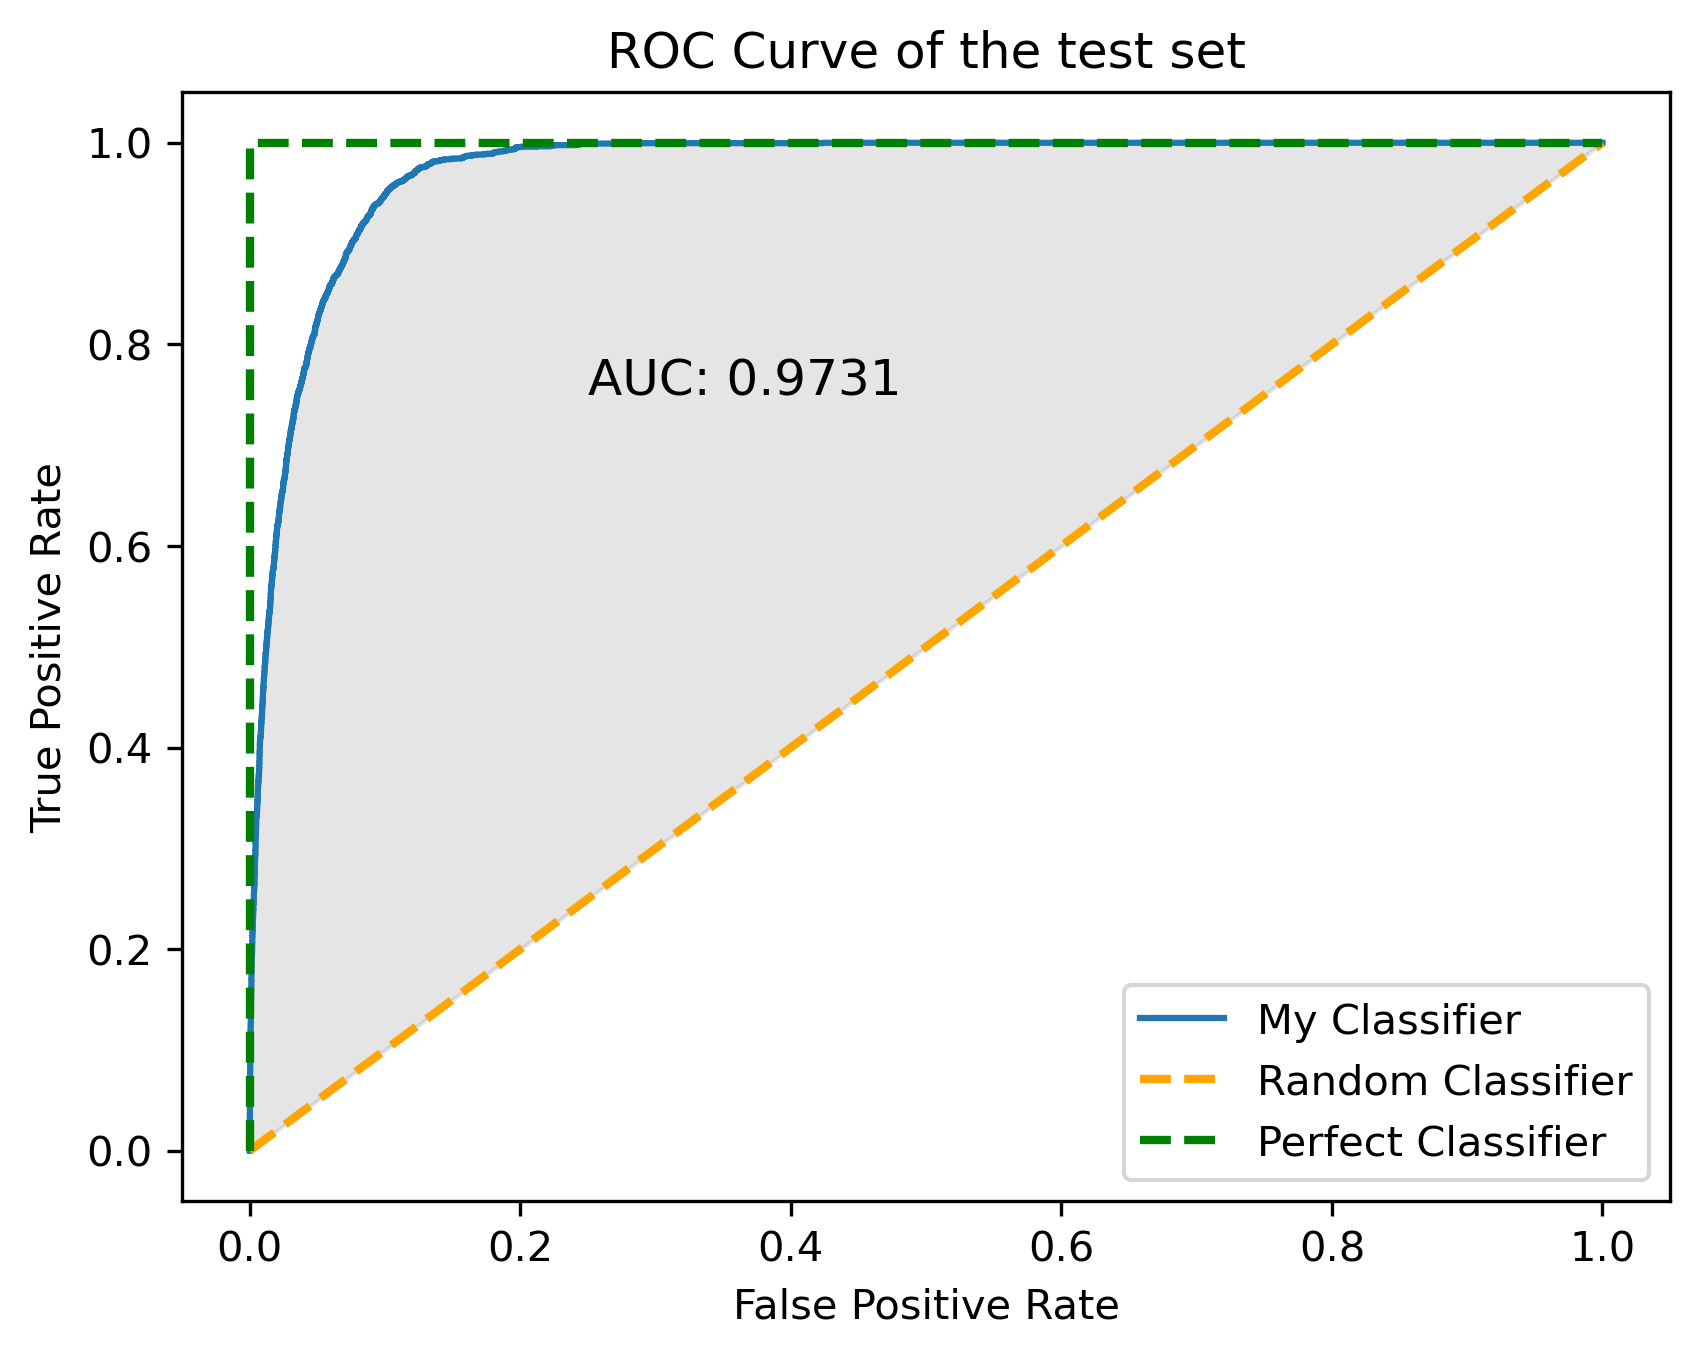

In [17]:
# Utils for the roc curve plotting
y_score = clf2.predict_proba(X_test_clf2)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = roc_auc_score(y_test, y_score)

# 3 classifiers to plot
my_curve = pd.DataFrame(tpr, index=fpr).iloc[:,0]
random = pd.DataFrame(fpr, index=fpr).iloc[:,0]
perf = [[0,0,1],[0,1,1]]

# Plot ROC curve
fig, ax = plt.subplots()
plt.plot(my_curve, label="My Classifier")
plt.plot(random, color='orange', lw=2, linestyle='--', label='Random Classifier')
plt.plot(perf[0], perf[1], color='green', lw=2, linestyle='--', label='Perfect Classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve of the test set')
plt.fill_between(fpr ,random,my_curve, color='grey', alpha=0.2)
plt.text(0.25, 0.75, 'AUC: {:.4f}'.format(auc), fontsize=12)
plt.show()

In [18]:
# Find best threshold on ROC Curve
fpr, tpr, thresh = roc_curve(y_train, clf2.predict_proba(X_train_clf2)[:,1]) # Compute ROC curve of trainset
g_mean = np.sqrt(tpr * (1-fpr)) # Geometric mean of recall and specificity
idx = np.argmax(g_mean) # Index of the best threshold
threshold_opt = thresh[idx] # Best threshold
print('Optimal threshold: {:.4f}'.format(threshold_opt))

Optimal threshold: 0.6644


In [19]:
# Predict testset playoff teams with the optimal threshold from trainset
pred_test = (clf2.predict_proba(X_test_clf2)[:,1] >= threshold_opt).astype(bool)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, pred_test)))

Accuracy score: 0.9520


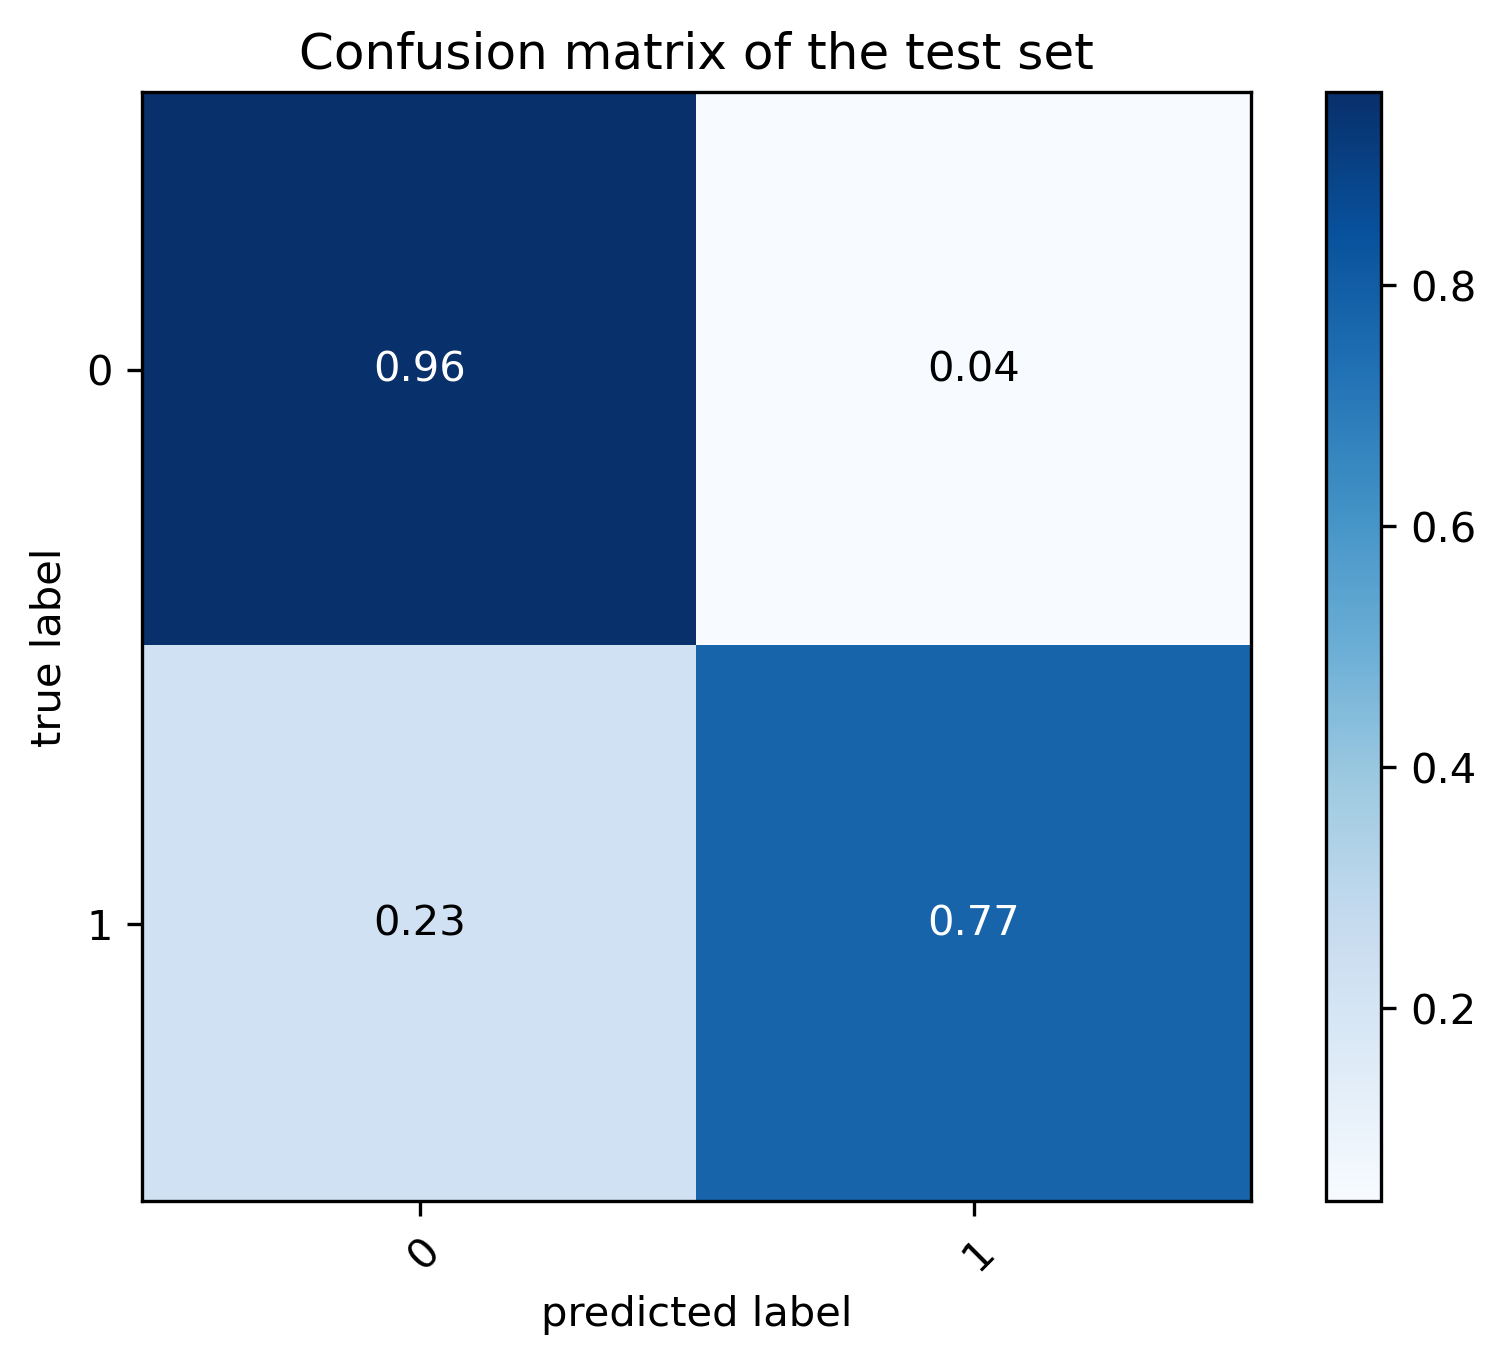

In [20]:
# Create test confusion matrix 
cm = confusion_matrix(y_test, pred_test)

# Plot test relative confusion matrix
figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = clf2.classes_,
                                   show_absolute = False,
                                   show_normed = True, # Relative to the true class
                                   colorbar = True)
plt.title('Confusion matrix of the test set')
plt.show()

With a ROC-AUC score of 97% and a 95% accuracy rate on the test set, the model can predict whether a roster will make the playoffs or not with remarkable accuracy, especially considering the amount of randomness involved in fantasy football. Additionnally, the confusion matrix reveals that the model performs well with both the actual playoff teams and the non-playoff teams.

## What contributes to a playoff roster?

In this section, we will examine the features that our model deems most significant. We will do this by utilizing SHAP values, which can be construed as the average marginal contribution of a feature to our predictions. Furthermore, we will analyze how the model determines which features have contributed to the triumph or setback of a particular team.

In [21]:
# Create shap values
explainer = TreeExplainer(clf)
shap_values = explainer(X_train)

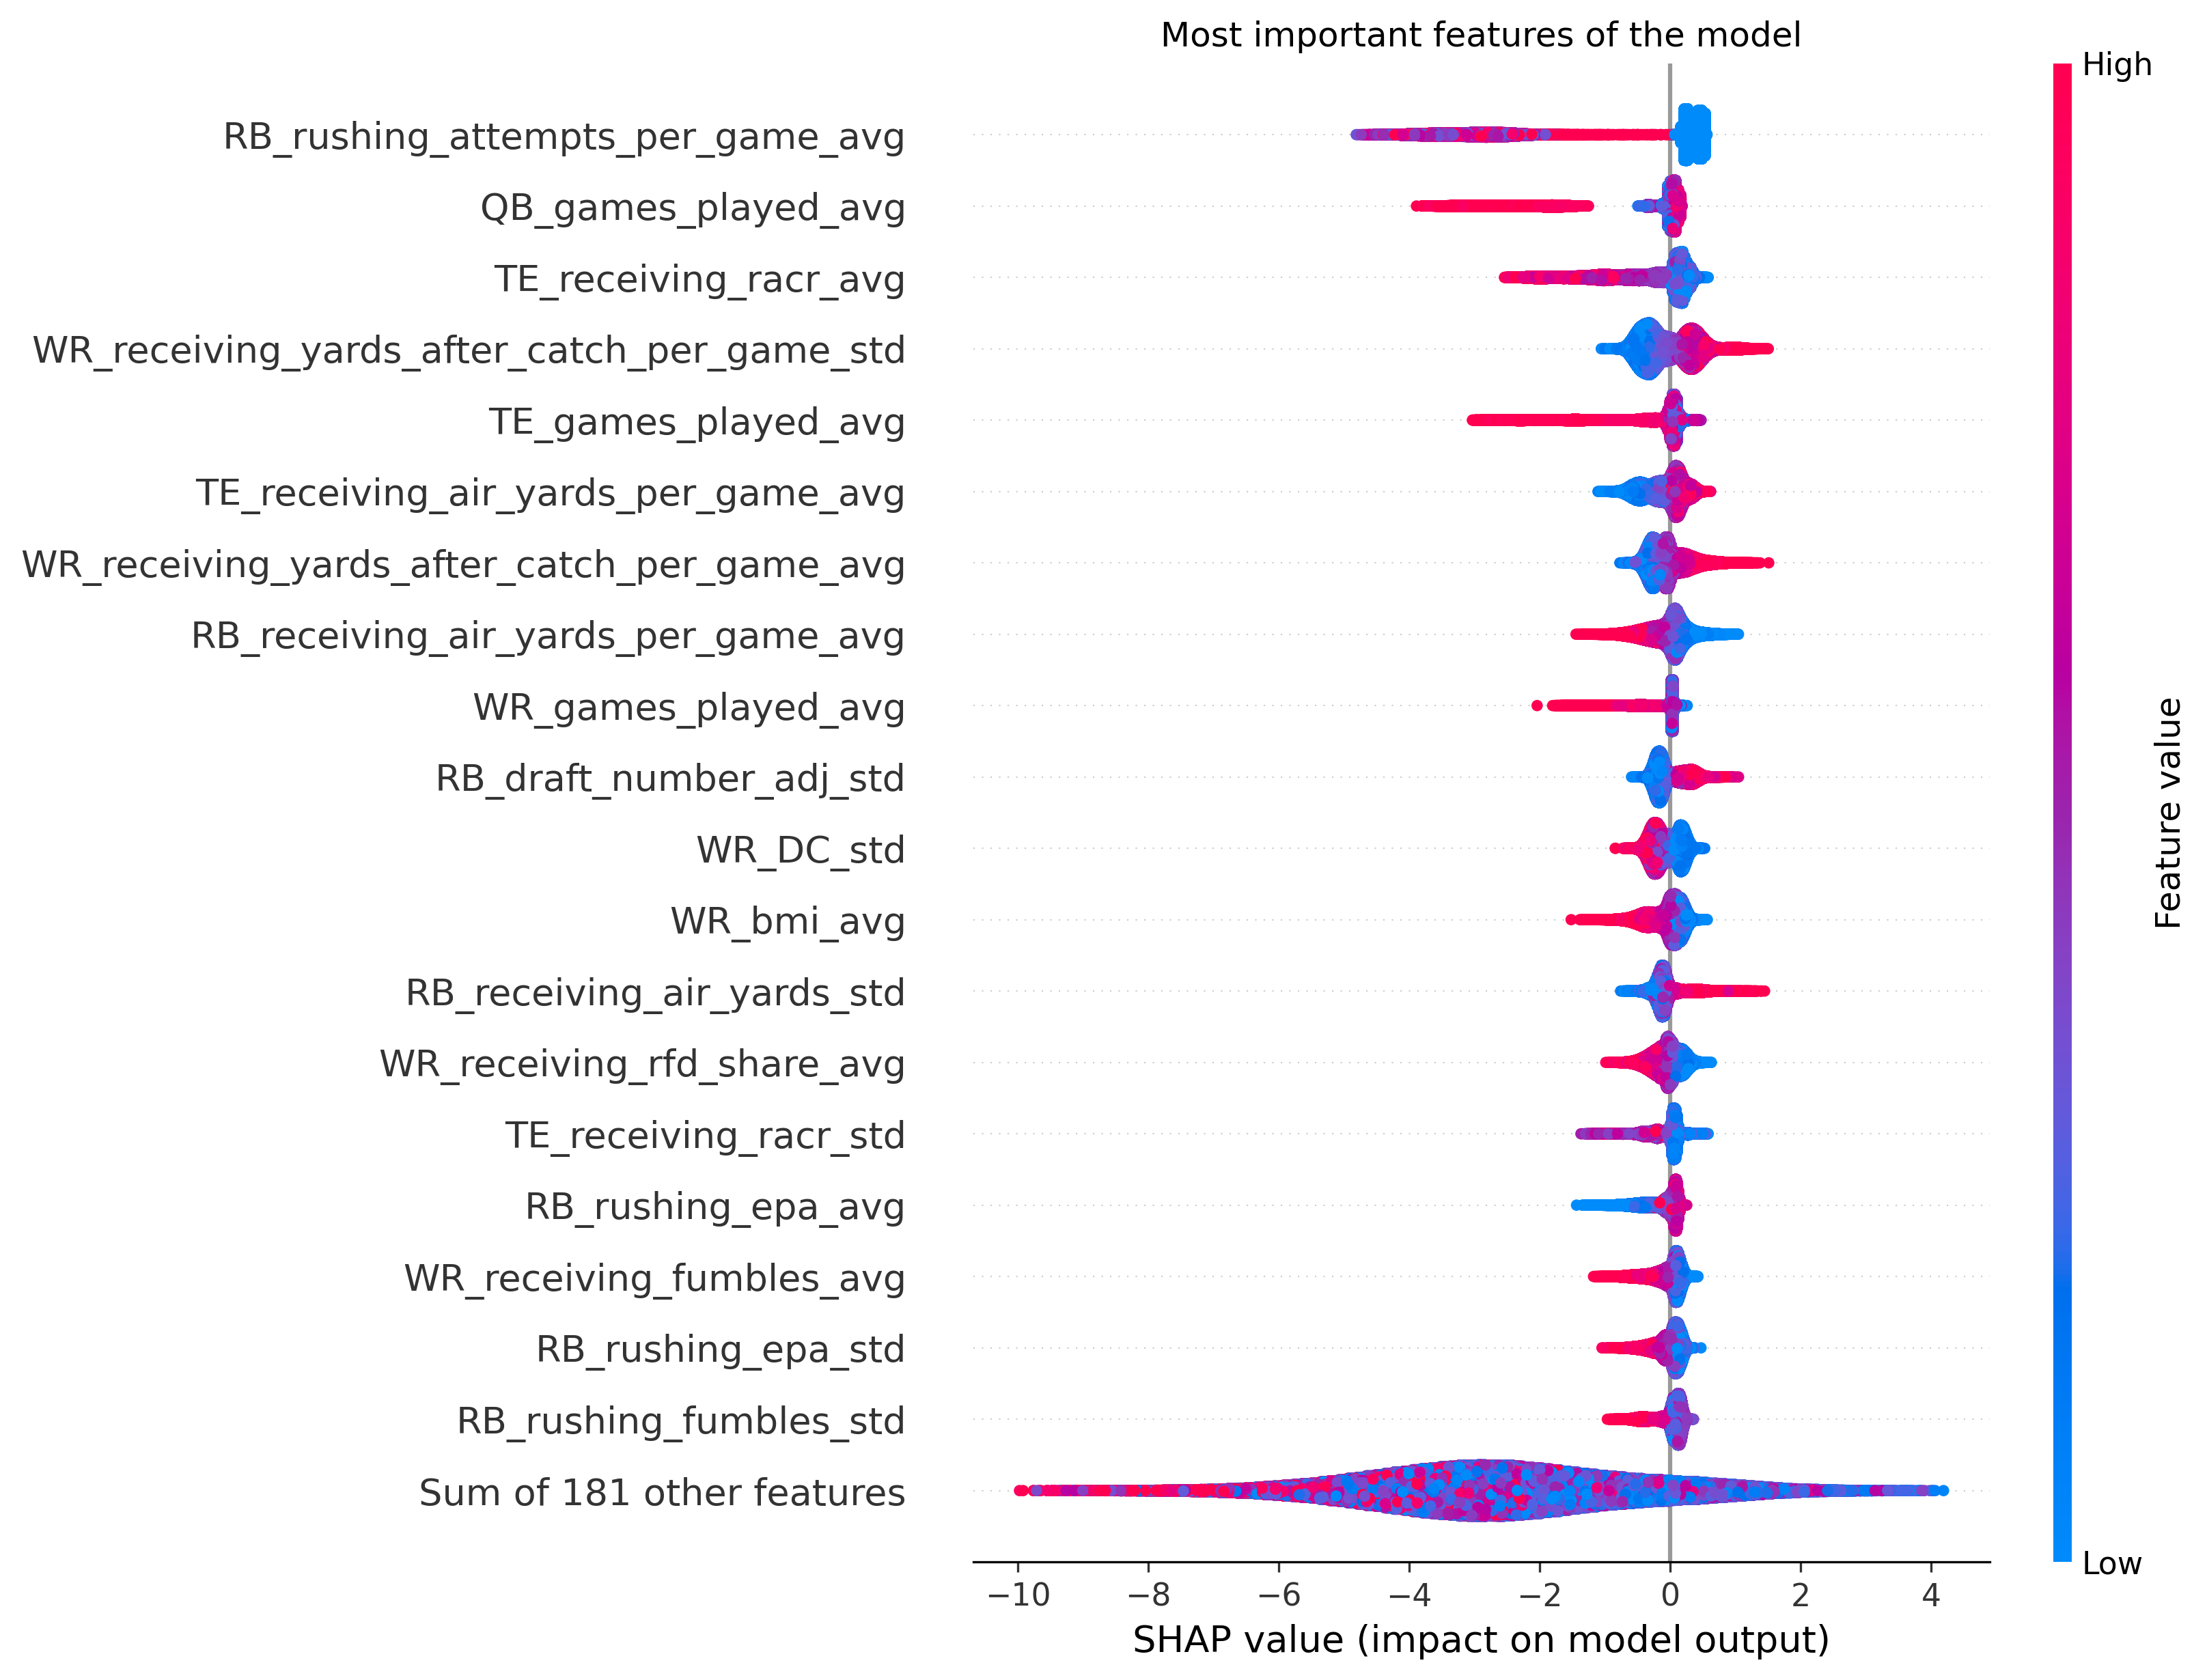

In [22]:
# Plot shap values
beeswarm(shap_values, max_display=20,show=False)
plt.title('Most important features of the model')
plt.show()

The graph itself conveys the message effectively, but I'd like to make a few observations. It is evident that investing in running backs with high carry numbers is an ineffective strategy, whereas investing in those with high receiving air yards is a lucrative one. Additionally, yard after catch for wide receivers holds significant importance. The variance of the Draft Capital associated with the WR position is also very predictive. Finally, it can be observed from the SHAP plot that the large number of features is justified, as it illustrates the significant contribution of the last 180 features to the model output.

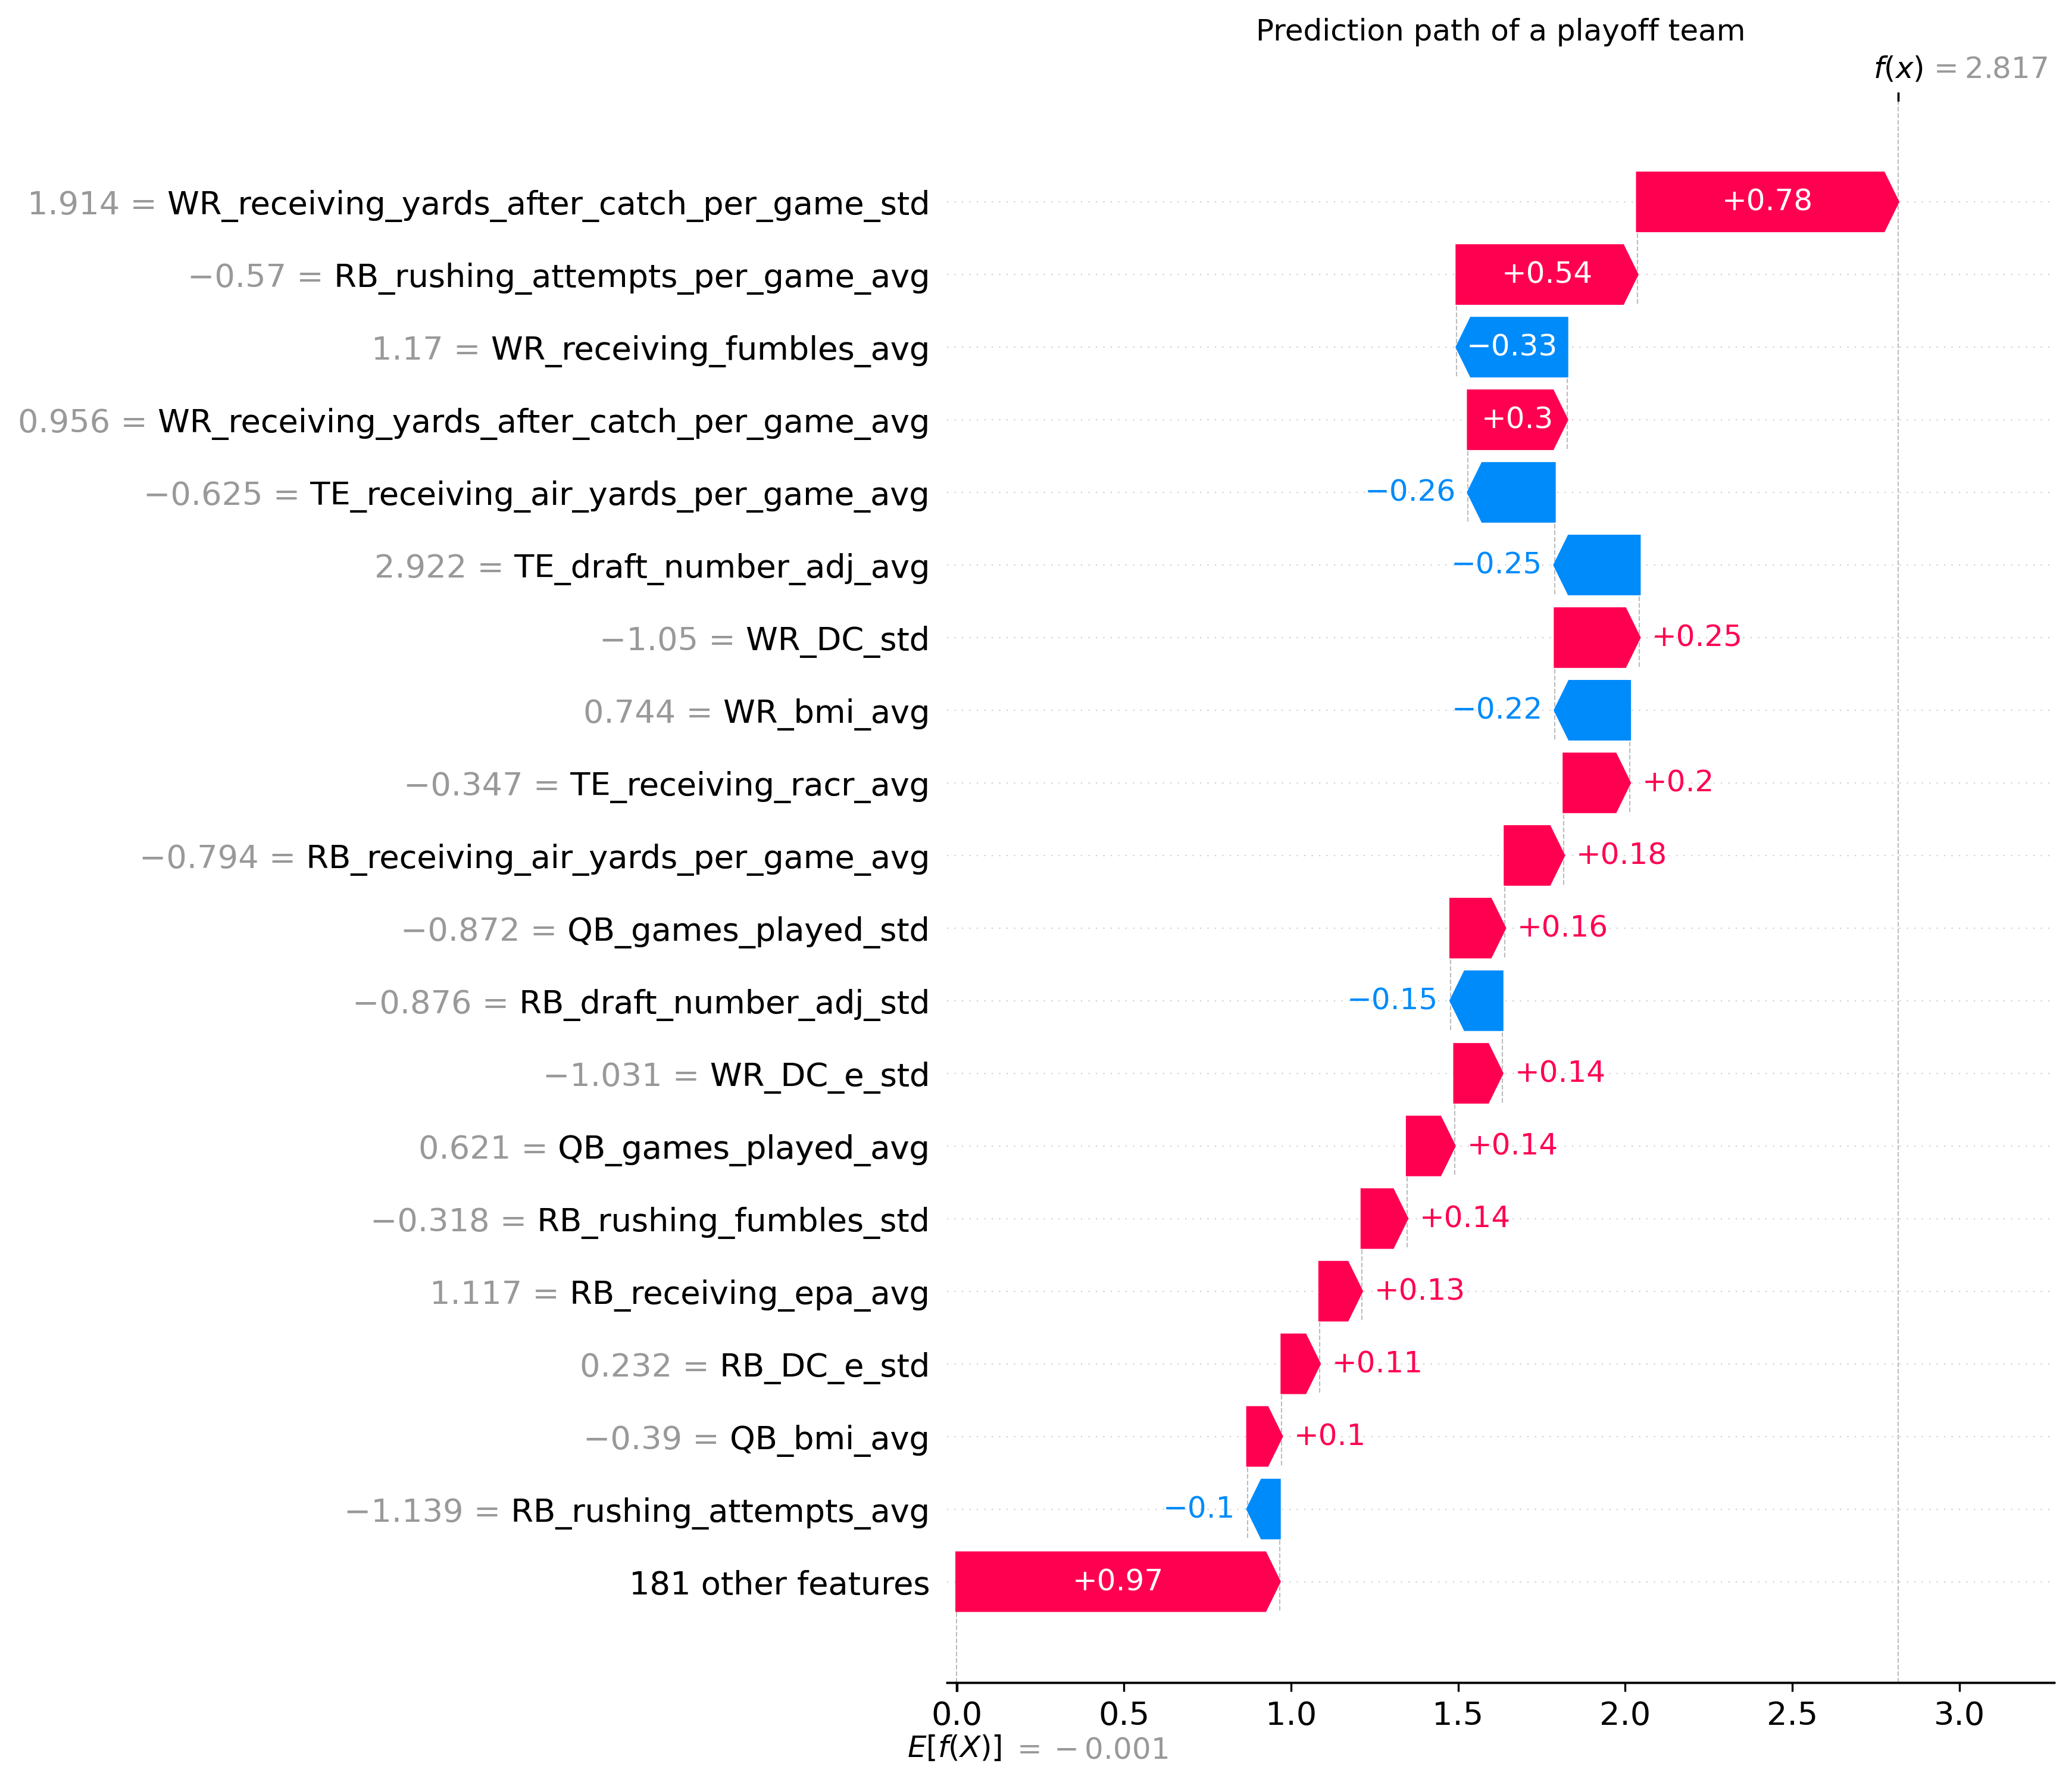

In [23]:
# Waterfall plot of playoff team
waterfall(shap_values[7], max_display=20,show=False)
plt.title('Prediction path of a playoff team')
plt.show()

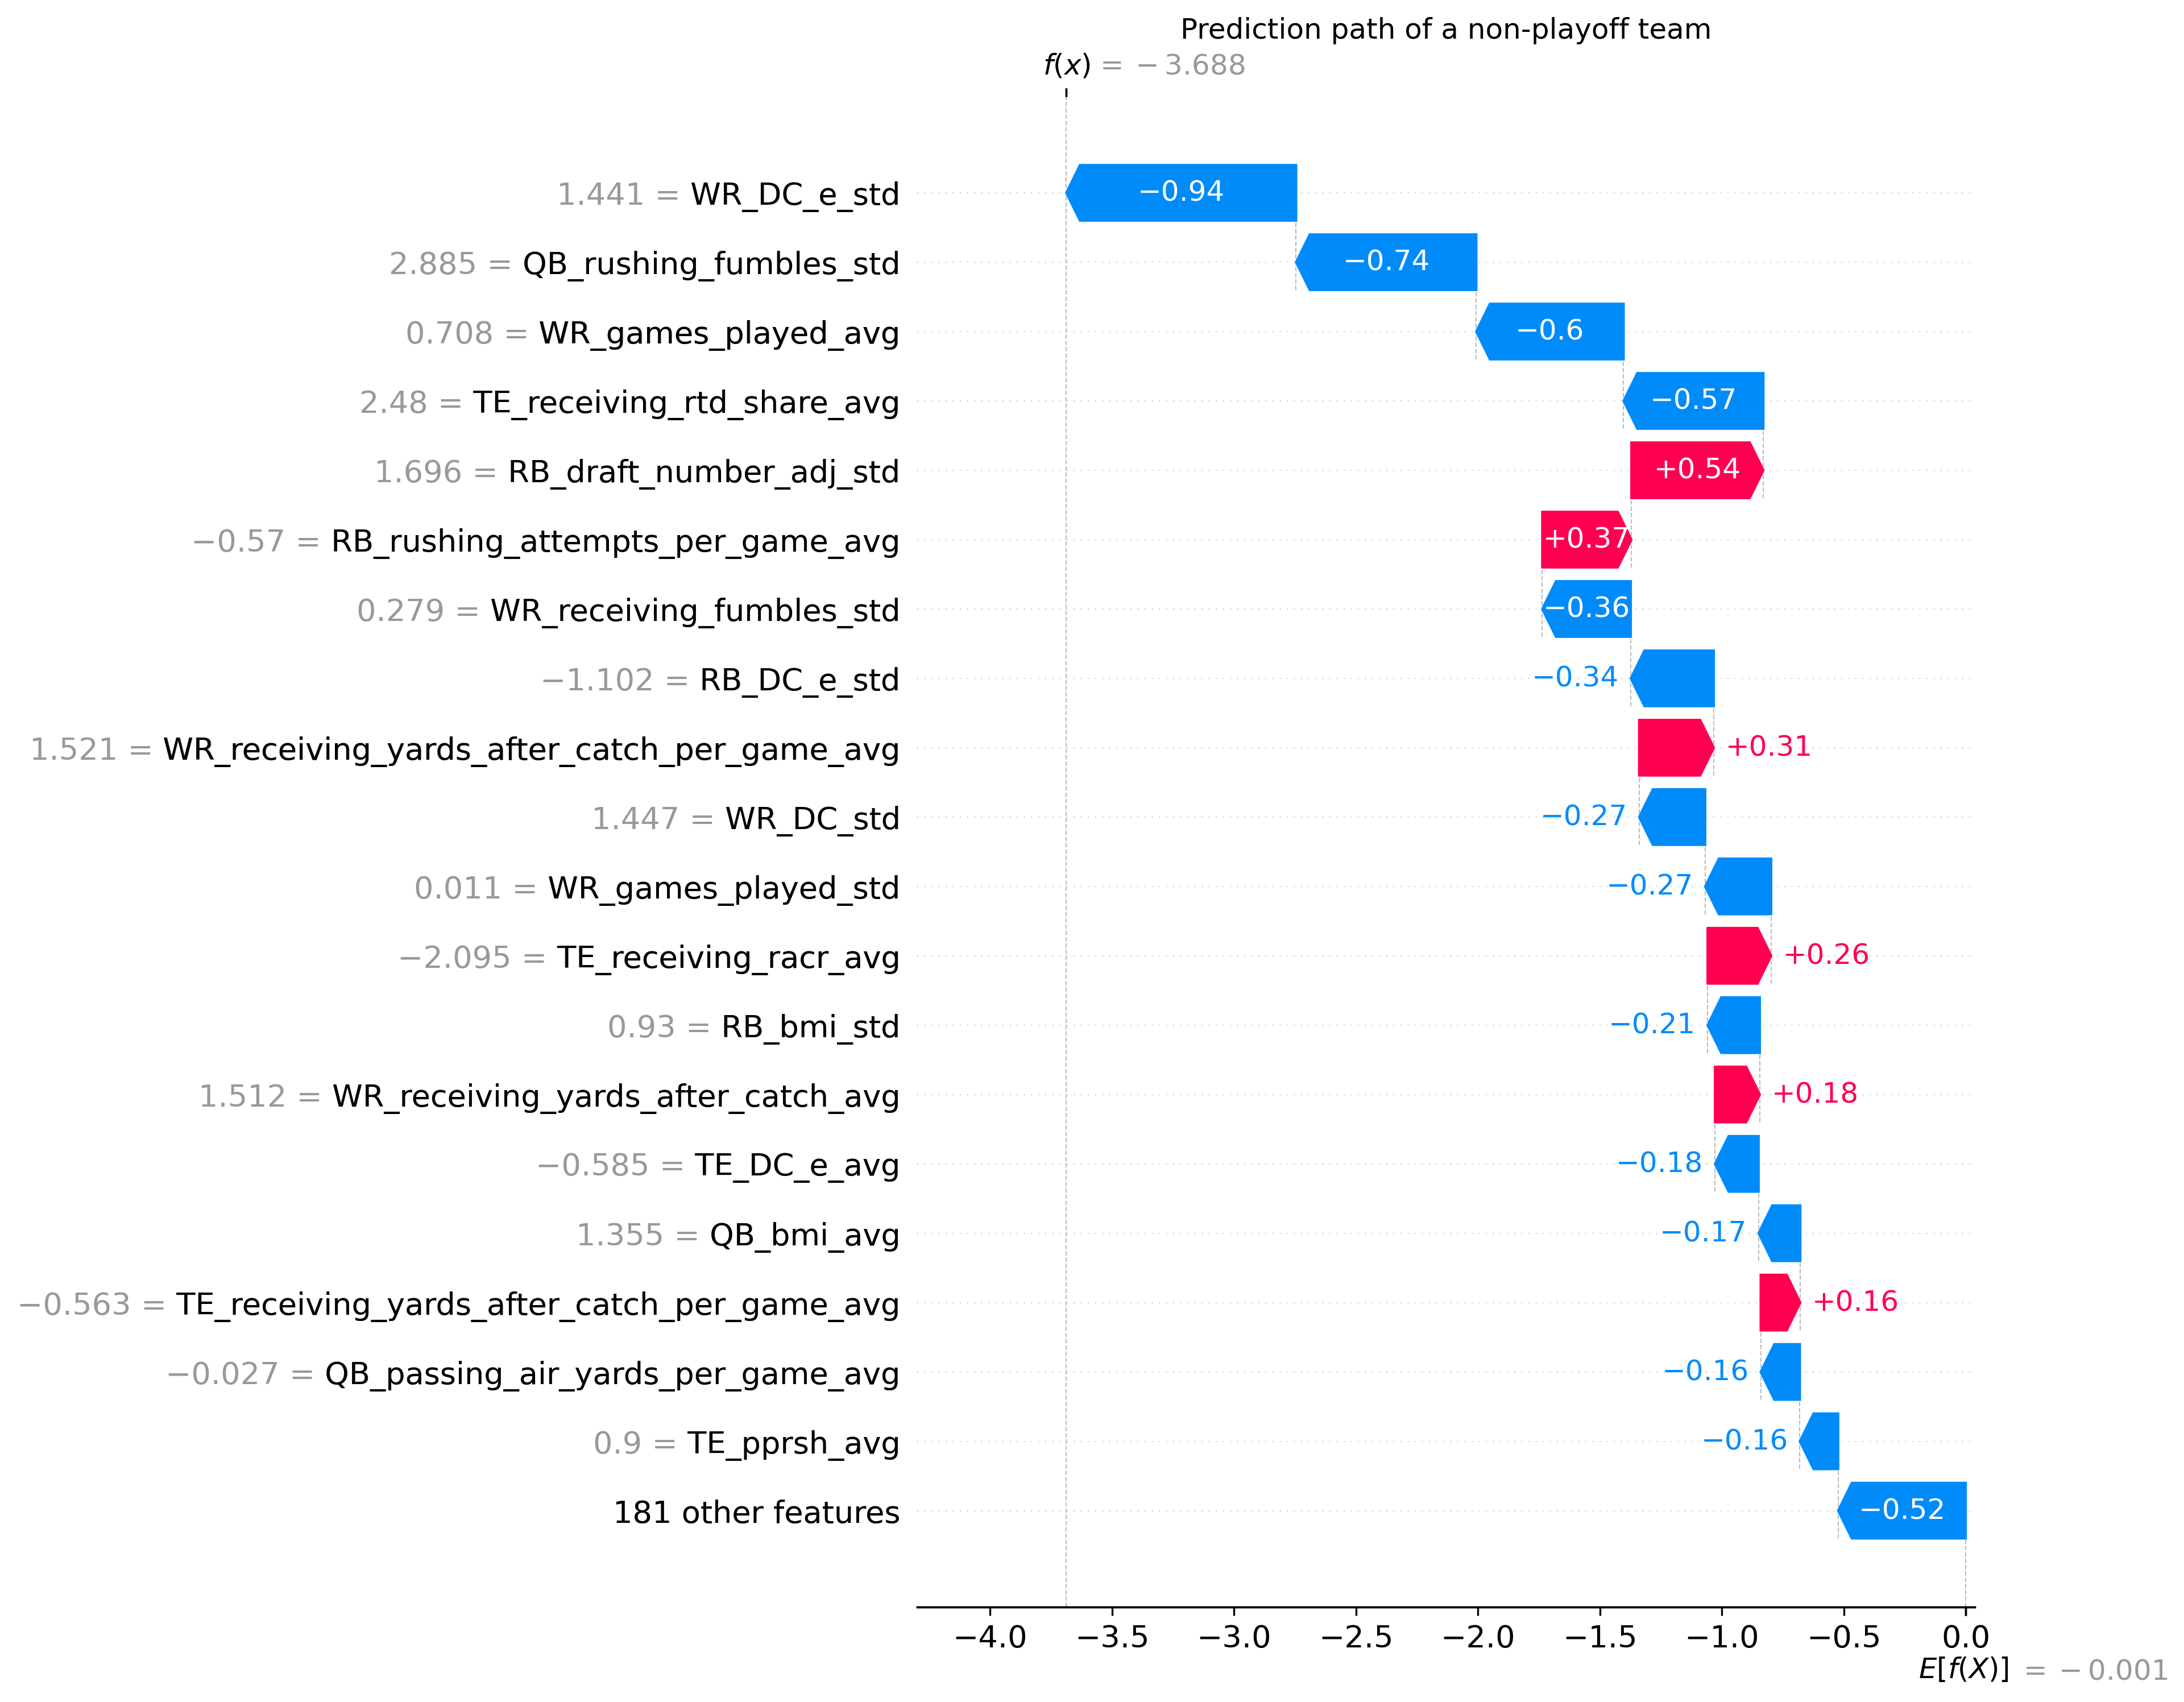

In [24]:
# Waterfall plot of non playoff team
waterfall(shap_values[2], max_display=20,show=False)
plt.title('Prediction path of a non-playoff team')
plt.show()

The initial waterfall graph pertains to a playoff team, whereas the subsequent graph is for a non-playoff team. We can observe how the model determines, based on different features, whether a roster is a victorious one.  Upon observation, it is evident that the main impact on a prediction is not always attributed to the same feature. The model is intricate and generates unique prediction paths for each team.

## Concluding remarks

The outcomes of this exercise have yielded noteworthy results. The Best Ball Value Curve is theoretically sound and appears to be highly predictive. The model we have constructed exhibits high levels of discrimination and accuracy. It could be implemented, along with its result analysis methodology, on the Underdog website with some fine-tuning and few heuristic adjustments. Should this transpire, I would be delighted to offer my contribution to the project. In addition, the SHAP values provide intuitive insights into how the model predicts playoff teams and validate several fantasy football heuristics, including the significance of YAC and running backs with strong pass-catching abilities.